In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load and pre-process the FashionMNIST dataset

In [2]:
#Define a transform to normalize the data and convert it to a tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) #Normalize pixel values to range [-1, 1]
])

#Download and load the training and test datasets
train_dataset_fashion = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_fashion = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

#Create data loaders
batch_size_fashion = 64 #A common batch size for image data
train_loader_fashion = DataLoader(train_dataset_fashion, batch_size=batch_size_fashion, shuffle=True)
test_loader_fashion = DataLoader(test_dataset_fashion, batch_size=batch_size_fashion, shuffle=False)

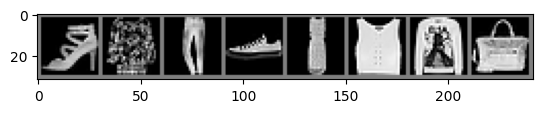

Sandal Shirt Trouser Sneaker Dress T-shirt/top Pullover Bag  


In [3]:
import matplotlib.pyplot as plt
import numpy as np

#Helper function to unnormalize images for display
def imshow(img):
    img = img / 2 + 0.5  #Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#Get a batch of training images
dataiter = iter(train_loader_fashion)
images, labels = next(dataiter)

#Show images
imshow(torchvision.utils.make_grid(images[:8])) #Display first 8 images

#Print labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

In [29]:
class FashionCNN(nn.Module):
    def __init__(self):
        super().__init__()

        #Input: 1 channel (grayscale images), output: 32 channels, kernel size 3x3
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)

        #Max pooling layer with 2x2 window and stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Input: 32 channels, output: 64 channels, kernel size 3x3
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        # Fully connected layer: input features will be calculated based on image size after conv/pool
        #FashionMNIST images are 28x28.
        #After conv1 (3x3 kernel, padding=1): 28x28
        #After pool (2x2, stride=2): 14x14
        #After conv2 (3x3 kernel, padding=1): 14x14
        #After pool (2x2, stride=2): 7x7
        #Number of features = 64 (channels) * 7 * 7

        self.fc1 = nn.Linear(64 * 3 * 3, 128) #128 neurons in the hidden layer
        self.fc2 = nn.Linear(128, 10) # 10 output classes for FashionMNIST

    def forward(self, x):
        #-> n, 1, 28, 28
        x = self.pool(F.relu(self.conv1(x))) #-> n, 32, 14, 14
        x = self.pool(F.relu(self.conv2(x))) #-> n, 64, 7, 7
        x = self.pool(F.relu(self.conv3(x))) #-> n, 64, 7, 7
        #Flatten the image for the fully connected layer
        x = torch.flatten(x,1) #-> n, 64 * 7 * 7
        x = F.relu(self.fc1(x)) #-> n, 128
        logits = self.fc2(x) #-> n, 10
        return logits

Instantiate model/loss/optimizer, and train!

In [ ]:
#Instantiate Model, Loss, and Optimizer
model_fashion = FashionCNN().to(device)
criterion_fashion = nn.CrossEntropyLoss()
optimizer_fashion = optim.Adam(model_fashion.parameters(), lr=0.001) #Slightly smaller learning rate for CNNs

#Training Loop
epochs_fashion = 10

print("\n--- Starting FashionMNIST CNN Training ---")
for epoch in range(epochs_fashion):
    model_fashion.train()
    total_loss_fashion = 0
    for batch_idx, (data, target) in enumerate(train_loader_fashion):
        data, target = data.to(device), target.to(device)

        optimizer_fashion.zero_grad()
        output = model_fashion(data)
        loss = criterion_fashion(output, target)
        loss.backward()
        optimizer_fashion.step()

        total_loss_fashion += loss.item()

    print(f"Epoch [{epoch+1}/{epochs_fashion}], Loss: {total_loss_fashion/len(train_loader_fashion):.4f}")

#Evaluation Loop
print("\n--- Starting FashionMNIST CNN Evaluation ---")
model_fashion.eval()
correct_fashion = 0
total_fashion = 0
with torch.no_grad():
    for data, target in test_loader_fashion:
        data, target = data.to(device), target.to(device)
        output = model_fashion(data)
        _, predicted = torch.max(output.data, 1)
        total_fashion += target.size(0)
        correct_fashion += (predicted == target).sum().item()

accuracy_fashion = correct_fashion / total_fashion
print(f"FashionMNIST CNN Test Accuracy: {accuracy_fashion:.4f}")


--- Starting FashionMNIST CNN Training ---
Epoch [1/10], Loss: 0.4943
Epoch [2/10], Loss: 0.2964
Epoch [3/10], Loss: 0.2531
